
**U ovom projektu korišten je skup podataka koji sadrži informacije o korisnicima telekomunikacijske kompanije i govori nam je li određeni korisnik otkazao uslugu ili ne.
Na temelju tih podataka gradi se neuronska mreža koja uči i predviđa hoće li korisnik napustiti uslugu kompanije ili ostati.**

In [13]:
import pandas as pd

In [14]:
telco_df = pd.read_csv("telco_dataset.csv")
telco_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [15]:
telco_df = telco_df.drop(columns=['customerID'])
print(telco_df.columns)
churn_distribution = telco_df.groupby('Churn').size()
print(churn_distribution)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
Churn
No     5174
Yes    1869
dtype: int64


In [16]:
telco_df.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch



X = telco_df.drop(["Churn"], axis=1)
y = telco_df["Churn"]

# Define categorical and numerical columns
categorical_columns = ["gender", "Partner", "Dependents", "PhoneService", "MultipleLines",
                        "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
                        "StreamingMovies", "InternetService", "OnlineSecurity", "Contract",
                        "PaperlessBilling", "PaymentMethod"]

numerical_columns = ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]


for col in numerical_columns:
    X[col] = pd.to_numeric(X[col].replace(' ', np.nan), errors='coerce')  # Convert to float


imputer = SimpleImputer(strategy='median')
X[numerical_columns] = imputer.fit_transform(X[numerical_columns])


X[categorical_columns] = X[categorical_columns].astype(str)


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


one_hot = OneHotEncoder(sparse_output=False, drop='first')  
scaler = StandardScaler()  


transformer = ColumnTransformer(
    transformers=[
        ("one_hot", one_hot, categorical_columns),
        ("scaler", scaler, numerical_columns)
    ],
    remainder="passthrough"
)


transformed_X = transformer.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size=0.3)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [18]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassificationModel(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


input_dim = X_train.shape[1]
model = BinaryClassificationModel(input_dim)
criterion = nn.BCELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [20]:
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

Epoch 1/100, Loss: 0.6470862288628855
Epoch 2/100, Loss: 0.5511436950775885
Epoch 3/100, Loss: 0.48987062496523703
Epoch 4/100, Loss: 0.4620804484813444
Epoch 5/100, Loss: 0.4493544401661042
Epoch 6/100, Loss: 0.441329445762019
Epoch 7/100, Loss: 0.4357628833863043
Epoch 8/100, Loss: 0.4341334971689409
Epoch 9/100, Loss: 0.42937655968050803
Epoch 10/100, Loss: 0.4307904980836376
Epoch 11/100, Loss: 0.4253798046419697
Epoch 12/100, Loss: 0.4255838191316974
Epoch 13/100, Loss: 0.42380106526036415
Epoch 14/100, Loss: 0.4218064700403521
Epoch 15/100, Loss: 0.42526290484013096
Epoch 16/100, Loss: 0.41879774928092955
Epoch 17/100, Loss: 0.4174500670163862
Epoch 18/100, Loss: 0.41963329344026506
Epoch 19/100, Loss: 0.4171058459628013
Epoch 20/100, Loss: 0.41986686779606724
Epoch 21/100, Loss: 0.41388966095062996
Epoch 22/100, Loss: 0.41193327922974865
Epoch 23/100, Loss: 0.4195034618339231
Epoch 24/100, Loss: 0.4109518306870614
Epoch 25/100, Loss: 0.41109276279326407
Epoch 26/100, Loss: 0.411

In [21]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 79.46%


In [22]:
from sklearn.metrics import classification_report, confusion_matrix  


model.eval()  

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()  
        all_labels.extend(labels.cpu().numpy()) 
        all_predictions.extend(predicted.cpu().numpy()) 


report = classification_report(all_labels, all_predictions, target_names=['Class 0', 'Class 1'])
print(report)

              precision    recall  f1-score   support

     Class 0       0.84      0.89      0.86      1553
     Class 1       0.63      0.54      0.58       560

    accuracy                           0.79      2113
   macro avg       0.74      0.71      0.72      2113
weighted avg       0.79      0.79      0.79      2113



Confusion Matrix:
[[1377  176]
 [ 258  302]]


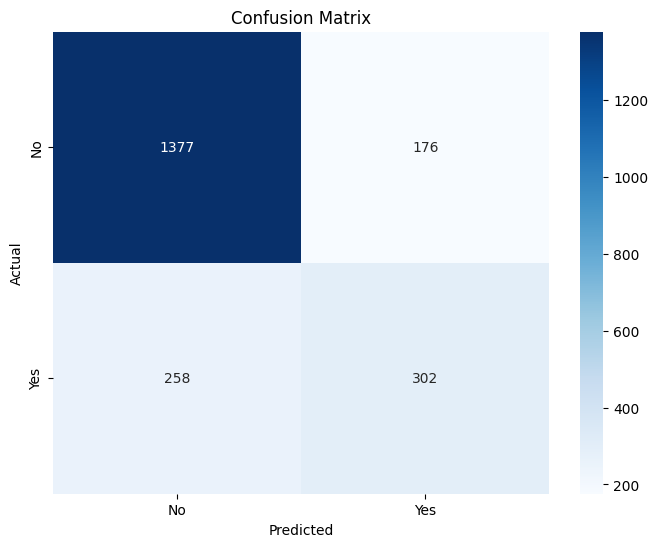

In [23]:

conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()